# Anomaly / Outlier / Novelty Detection

**In some cases, training data contain anomalies.  These are a minority of all training observations.**

**In other cases, training data contain only regular, non-deviant observations.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Isolation Forests

**The idea is to isolate individual observations.  For each observation, we measure the number of splits ("path length") required to isolate it, then find the average path length across trees in the forest.  Average path length (APL) is thresholded: observations with APL below this threshold are declared to be anomalies.**

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
rng = np.random.RandomState(42) # for reproducibility

In [21]:
from sklearn.ensemble import IsolationForest

In [29]:
# GENERATE SYNTHETIC DATA
X = 0.3 * rng.randn(100,2)
# 100 ordered pairs drawn from standard normal distribution, then multiplied by 0.3
# Why 0.3?

In [30]:
X_train = np.r_[X+2,X-2]
# 200 ordered pairs, 100 clustered near (2,2) and 100 clustered near (-2,-2)

In [31]:
X_train.shape

(200, 2)

In [32]:
X = 0.3 * rng.randn(20,2)

In [33]:
X_test_reg = np.r_[X + 2, X - 2]

In [34]:
X_test_reg.shape

(40, 2)

In [36]:
X_test_anom = rng.uniform(low = -4, high = +4, size = (20,2))
# Now drawing 20 ordered pairs, with the 40 numbers uniformly distributed between -4 and 4

In [37]:
X_test_anom.shape

(20, 2)

In [92]:
# Instantiate an IsolationForest object
model = IsolationForest(max_samples=100, random_state=rng, n_estimators=100, contamination=0.1, verbose=1)
# 100 samples (out of 200 total) used in each tree
# 100 total trees
# Does contamination refer only to the training set?  If so, shouldn't contamination = 0?
# Perhaps contamination = 0 would lead to overfitting.
# max_features = 1; only have 2 total features

In [93]:
model.fit(X_train)
# Is this unsupervised, or is it just a one-class problem, since all training samples belong to the "regular" class?
# sample_weight = None

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples=100, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x1a136f3678>,
        verbose=1)

In [94]:
y_pred_train = model.predict(X_train)

In [95]:
np.unique(y_pred_train, return_counts = True)
# -1 signifies outlier, +1 signifies inlier
# So 10% of training data identified as anomalous.

(array([-1,  1]), array([ 20, 180]))

In [96]:
y_pred_test_reg = model.predict(X_test_reg)

In [97]:
np.unique(y_pred_test_reg, return_counts = True)

(array([-1,  1]), array([ 6, 34]))

In [98]:
y_pred_test_anom = model.predict(X_test_anom)

In [99]:
np.unique(y_pred_test_anom, return_counts = True) # 18 out of 20 identified as anomalies - impressive!

(array([-1,  1]), array([18,  2]))

In [100]:
model.max_samples_

100

In [101]:
anomaly_scores = model.decision_function(X_train)

In [102]:
anomaly_scores[anomaly_scores < 0].shape # How can anomaly scores (leaf depths) be negative?

(70,)

In [103]:
original_paper_scores = [-1*s - .5 for s in anomaly_scores]

### Visualization

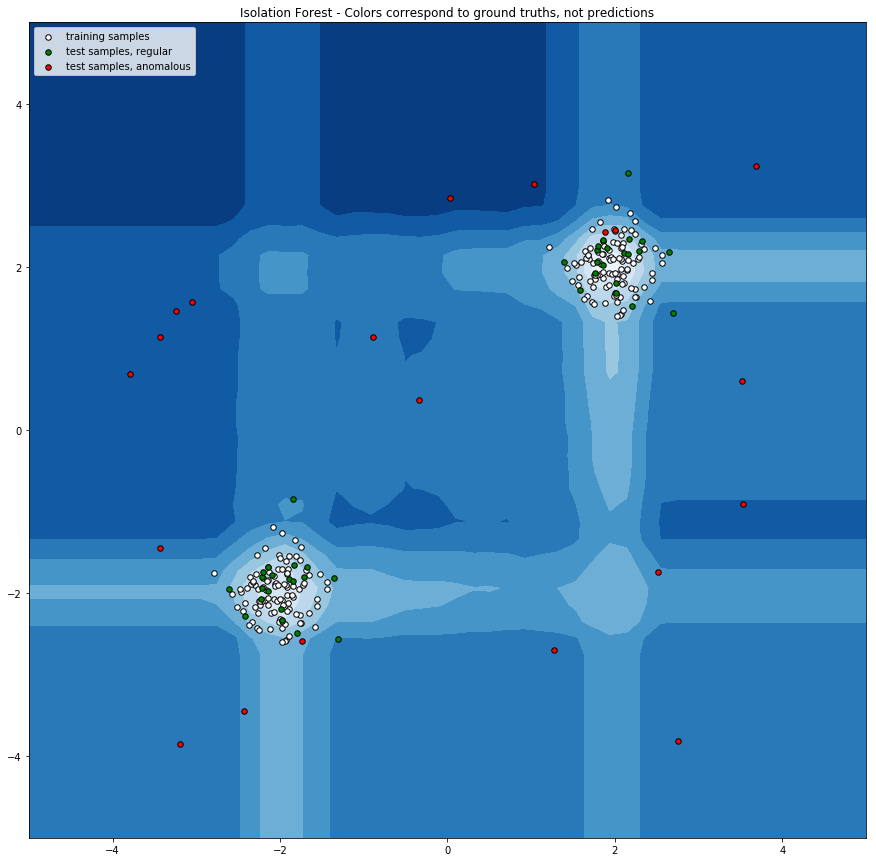

In [108]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))

Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,15))
plt.title("Isolation Forest - Colors correspond to ground truths, not predictions")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
# cm.Blues_r is inversion of cm.Blues
# Could really use a colorbar here

s = 30
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolor='black')
b2 = plt.scatter(X_test_reg[:, 0], X_test_reg[:, 1], c='green', s=s, edgecolor='black')
c = plt.scatter(X_test_anom[:, 0], X_test_anom[:, 1], c='red', s=s, edgecolor='black')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

plt.legend([b1, b2, c],
           ["training samples",
            "test samples, regular", "test samples, anomalous"],
           loc="upper left")

plt.show()

## One-class SVM

- **Using same synthetic data as before**
- **Using Radial Basis Function as kernel**

In [63]:
from sklearn.svm import OneClassSVM

In [109]:
model = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1, random_state=rng, verbose=1)
# nu gives upper bound on fraction of training errors
# rbf is *Radial Basis Function*
# Why is gamma set to 0.1?

In [110]:
model.fit(X_train)
# sample_weight = None
# No anomalies are present in training set

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1,
      random_state=<mtrand.RandomState object at 0x1a136f3678>,
      shrinking=True, tol=0.001, verbose=1)

In [111]:
y_pred_train = model.predict(X_train)

In [112]:
np.unique(y_pred_train, return_counts=True)
# Violates upper bound for error on training set...

(array([-1,  1]), array([ 21, 179]))

In [113]:
y_pred_test_reg = model.predict(X_test_reg)

In [114]:
np.unique(y_pred_test_reg, return_counts=True) # 7 samples out of 40 mistakenly predicted as outliers

(array([-1,  1]), array([ 7, 33]))

In [115]:
y_pred_test_anom = model.predict(X_test_anom)

In [116]:
np.unique(y_pred_test_anom, return_counts=True) # 2 samples out of 20 mistakenly predicted as inliers

(array([-1,  1]), array([18,  2]))

In [117]:
model.decision_function(X_test_anom)
# Signed distance is positive for a predicted inlier and negative for a predicted outlier.
# The two misses are just barely positive.

array([[-3.05686276],
       [-5.64735709],
       [-6.19633005],
       [-5.85449189],
       [-3.10304136],
       [-3.04224601],
       [-1.82971412],
       [-6.02311725],
       [-2.8447442 ],
       [-1.55750418],
       [-3.2258535 ],
       [-6.52597974],
       [-1.70490095],
       [-8.60182273],
       [-6.25097698],
       [-6.49271191],
       [-1.35446098],
       [ 0.13283857],
       [-0.10584809],
       [ 0.12931564]])

In [118]:
y_pred_test_anom

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1,  1])

### Visualization

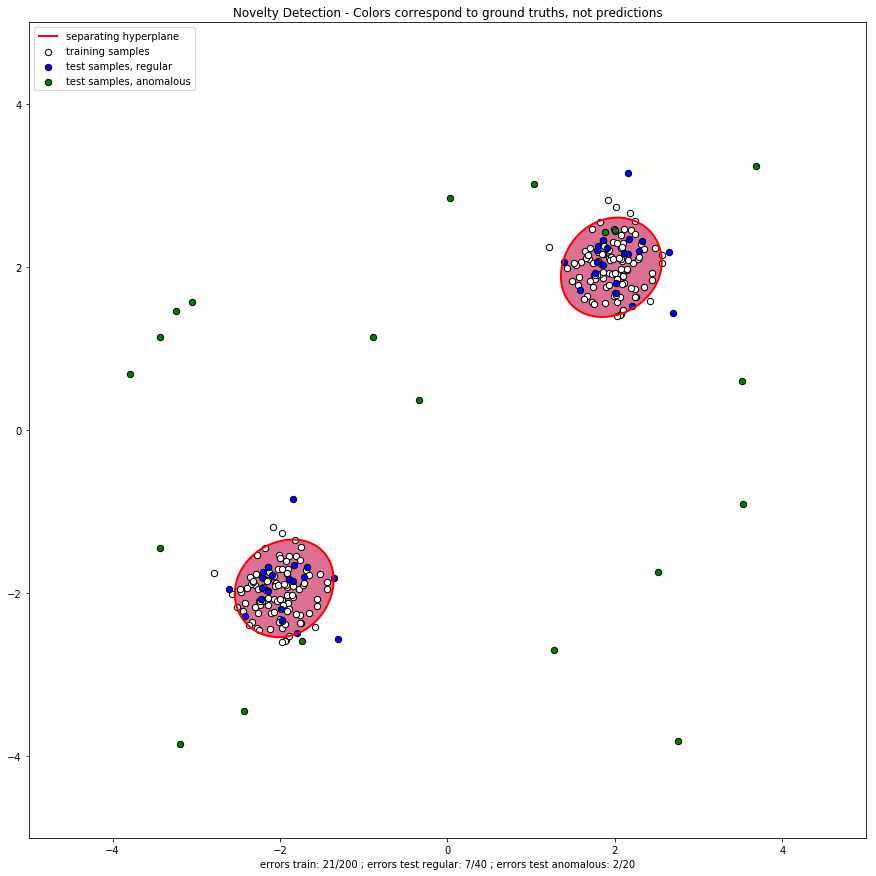

In [121]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test_reg = y_pred_test_reg[y_pred_test_reg == -1].size
n_error_test_anom = y_pred_test_anom[y_pred_test_anom == 1].size

Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,15))
plt.title("Novelty Detection - Colors correspond to ground truths, not predictions")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# linspace to enable partitioning
# Z.min() is negative
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red') # Zero level set of decision function
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='black')
b2 = plt.scatter(X_test_reg[:, 0], X_test_reg[:, 1], c='blue', s=s, edgecolors='black')
c = plt.scatter(X_test_anom[:, 0], X_test_anom[:, 1], c='green', s=s, edgecolors='black')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

plt.legend([a.collections[0], b1, b2, c],
           ["separating hyperplane", "training samples",
            "test samples, regular", "test samples, anomalous"],
           loc="upper left")

plt.xlabel(
    "errors train: %d/200 ; errors test regular: %d/40 ; errors test anomalous: %d/20"
    % (n_error_train, n_error_test_reg, n_error_test_anom))

plt.show()